# MxNet ConvNet on Picachu (yay!) dataset

Based on: https://gluon.mxnet.io/chapter08_computer-vision/object-detection.html
- CNN intro: https://acadgild.com/blog/convolutional-neural-network-cnn
- Missing pikachas: http://courses.csail.mit.edu/18.337/2017/projects/morales_manuel/img/pikachu.jpg
- Environment: 32 GB, 8 Intel Xeon CPU, 4 Nvidia GPU cards

Deps:
- sudo apt-get install libopencv-*

TODO:
- Implement multi-gpu training


In [1]:
import mxnet as mx
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior
import matplotlib.pyplot as plt
from mxnet.gluon import nn

n = 40 # shape: batch x channel x height x weight
x = nd.random_uniform(shape=(1, 3, n, n))
y = MultiBoxPrior(x, sizes=[.5, .25, .1], ratios=[1, 2, .5])
print(type(y))
# the first anchor box generated for pixel at (20,20)
# its format is (x_min, y_min, x_max, y_max)
boxes = y.reshape((n, n, -1, 4))
#print('The first anchor box at row 21, column 21:', boxes[20, 20, 0, :])
print(y.shape)
print(boxes.shape)

<class 'mxnet.ndarray.ndarray.NDArray'>
(1, 8000, 4)
(40, 40, 5, 4)


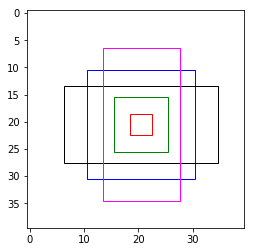

In [2]:
def box_to_rect(box, color, linewidth=1):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), (box[2]-box[0]), (box[3]-box[1]),
        fill=False, edgecolor=color, linewidth=linewidth)

colors = ['blue', 'green', 'red', 'black', 'magenta']
plt.imshow(nd.ones((n, n, 3)).asnumpy())
anchors = boxes[20, 20, :, :]
for i in range(anchors.shape[0]):
    plt.gca().add_patch(box_to_rect(anchors[i,:]*n, colors[i]))
plt.show()

In [3]:
def class_predictor(num_anchors, num_classes):
    """return a layer to predict classes"""
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

cls_pred = class_predictor(5, 10)
cls_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
print('Class prediction shape', cls_pred(x).shape)

Class prediction shape (2, 55, 20, 20)


In [4]:
def box_predictor(num_anchors):
    """return a layer to predict delta locations"""
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

box_pred = box_predictor(10)
box_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
print('Box prediction', box_pred(x).shape)

Box prediction (2, 40, 20, 20)


In [5]:
def down_sample(num_filters):
    """stack two Conv-BatchNorm-Relu blocks and then a pooling layer
    to halve the feature size"""
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

blk = down_sample(10)
blk.initialize()
x = nd.zeros((2, 3, 20, 20))
print('Before', x.shape, 'after', blk(x).shape)

Before (2, 3, 20, 20) after (2, 10, 10, 10)


In [6]:
# a certain feature map with 20x20 spatial shape
feat1 = nd.zeros((2, 8, 20, 20))
print('Feature map 1', feat1.shape)
cls_pred1 = class_predictor(5, 10)
cls_pred1.initialize()
y1 = cls_pred1(feat1)
print('Class prediction for feature map 1', y1.shape)
# down-sample
ds = down_sample(16)
ds.initialize()
feat2 = ds(feat1)
print('Feature map 2', feat2.shape)
cls_pred2 = class_predictor(3, 10)
cls_pred2.initialize()
y2 = cls_pred2(feat2)
print('Class prediction for feature map 2', y2.shape)

Feature map 1 (2, 8, 20, 20)
Class prediction for feature map 1 (2, 55, 20, 20)
Feature map 2 (2, 16, 10, 10)
Class prediction for feature map 2 (2, 33, 10, 10)


In [7]:
def flatten_prediction(pred):
    return nd.flatten(nd.transpose(pred, axes=(0, 2, 3, 1)))

def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

flat_y1 = flatten_prediction(y1)
print('Flatten class prediction 1', flat_y1.shape)
flat_y2 = flatten_prediction(y2)
print('Flatten class prediction 2', flat_y2.shape)
print('Concat class predictions', concat_predictions([flat_y1, flat_y2]).shape)

Flatten class prediction 1 (2, 22000)
Flatten class prediction 2 (2, 3300)
Concat class predictions (2, 25300)


In [8]:
from mxnet import gluon
def body():
    """return the body network"""
    out = nn.HybridSequential()
    for nfilters in [16, 32, 64]:
        out.add(down_sample(nfilters))
    return out

bnet = body()
bnet.initialize()
x = nd.zeros((2, 3, 256, 256))
print('Body network', [y.shape for y in bnet(x)])

Body network [(64, 32, 32), (64, 32, 32)]


In [9]:
def toy_ssd_model(num_anchors, num_classes):
    """return SSD modules"""
    downsamples = nn.Sequential()
    class_preds = nn.Sequential()
    box_preds = nn.Sequential()

    downsamples.add(down_sample(128))
    downsamples.add(down_sample(128))
    downsamples.add(down_sample(128))

    for scale in range(5):
        class_preds.add(class_predictor(num_anchors, num_classes))
        box_preds.add(box_predictor(num_anchors))

    return body(), downsamples, class_preds, box_preds

print(toy_ssd_model(5, 2))

(HybridSequential(
  (0): HybridSequential(
    (0): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(fix_gamma=False, momentum=0.9, axis=1, eps=1e-05, use_global_stats=False, in_channels=16)
    (2): Activation(relu)
    (3): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm(fix_gamma=False, momentum=0.9, axis=1, eps=1e-05, use_global_stats=False, in_channels=16)
    (5): Activation(relu)
    (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  )
  (1): HybridSequential(
    (0): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(fix_gamma=False, momentum=0.9, axis=1, eps=1e-05, use_global_stats=False, in_channels=32)
    (2): Activation(relu)
    (3): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm(fix_gamma=False, momentum=0.9, axis=1, eps=1e-05, use_global_stats=False, in_channels=32)
    (5): Activati

In [10]:
def toy_ssd_forward(x, body, downsamples, class_preds, box_preds, sizes, ratios):
    # extract feature with the body network
    x = body(x)

    # for each scale, add anchors, box and class predictions,
    # then compute the input to next scale
    default_anchors = []
    predicted_boxes = []
    predicted_classes = []

    for i in range(5):
        default_anchors.append(MultiBoxPrior(x, sizes=sizes[i], ratios=ratios[i]))
        predicted_boxes.append(flatten_prediction(box_preds[i](x)))
        predicted_classes.append(flatten_prediction(class_preds[i](x)))
        if i < 3:
            x = downsamples[i](x)
        elif i == 3:
            # simply use the pooling layer
            x = nd.Pooling(x, global_pool=True, pool_type='max', kernel=(4, 4))

    return default_anchors, predicted_classes, predicted_boxes

In [11]:
class ToySSD(gluon.Block):
    def __init__(self, num_classes, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # anchor box sizes for 4 feature scales
        self.anchor_sizes = [[.2, .272], [.37, .447], [.54, .619], [.71, .79], [.88, .961]]
        # anchor box ratios for 4 feature scales
        self.anchor_ratios = [[1, 2, .5]] * 5
        self.num_classes = num_classes

        with self.name_scope():
            self.body, self.downsamples, self.class_preds, self.box_preds = toy_ssd_model(4, num_classes)

    def forward(self, x):
        default_anchors, predicted_classes, predicted_boxes = toy_ssd_forward(x, self.body, self.downsamples,
            self.class_preds, self.box_preds, self.anchor_sizes, self.anchor_ratios)
        # we want to concatenate anchors, class predictions, box predictions from different layers
        anchors = concat_predictions(default_anchors)
        box_preds = concat_predictions(predicted_boxes)
        class_preds = concat_predictions(predicted_classes)
        # it is better to have class predictions reshaped for softmax computation
        class_preds = nd.reshape(class_preds, shape=(0, -1, self.num_classes + 1))

        return anchors, class_preds, box_preds

In [12]:
# instantiate a ToySSD network with 10 classes
net = ToySSD(2)
net.initialize()
x = nd.zeros((1, 3, 256, 256))
default_anchors, class_predictions, box_predictions = net(x)
print('Outputs:', 'anchors', default_anchors.shape, 'class prediction', class_predictions.shape, 'box prediction', box_predictions.shape)

Outputs: anchors (1, 5444, 4) class prediction (1, 5444, 3) box prediction (1, 21776)


In [13]:
from mxnet.test_utils import download
import os.path as osp
def verified(file_path, sha1hash):
    import hashlib
    sha1 = hashlib.sha1()
    with open(file_path, 'rb') as f:
        while True:
            data = f.read(1048576)
            if not data:
                break
            sha1.update(data)
    matched = sha1.hexdigest() == sha1hash
    if not matched:
        print('Found hash mismatch in file {}, possibly due to incomplete download.'.format(file_path))
    return matched

url_format = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/{}'
hashes = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
          'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
          'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
for k, v in hashes.items():
    fname = 'pikachu_' + k
    target = osp.join('data', fname)
    url = url_format.format(k)
    if not osp.exists(target) or not verified(target, v):
        print('Downloading', target, url)
        download(url, fname=fname, dirname='data', overwrite=True)

In [14]:
import mxnet.image as image
data_shape = 256
batch_size = 16
def get_iterators(data_shape, batch_size):
    class_names = ['pikachu']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec='./data/pikachu_train.rec',
        path_imgidx='./data/pikachu_train.idx',
        shuffle=True,
        mean=True,
        rand_crop=1,
        min_object_covered=0.95,
        max_attempts=200)
    val_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec='./data/pikachu_val.rec',
        shuffle=False,
        mean=True)
    return train_iter, val_iter, class_names, num_class

train_data, test_data, class_names, num_class = get_iterators(data_shape, batch_size)
batch = train_data.next()
print(batch)

DataBatch: data shapes: [(16, 3, 256, 256)] label shapes: [(16, 1, 5)]


[ 0.          0.46450537  0.36031654  0.57762086  0.53338164]


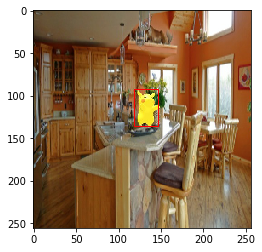

In [15]:
import numpy as np

img = batch.data[0][0].asnumpy()  # grab the first image, convert to numpy array
img = img.transpose((1, 2, 0))  # we want channel to be the last dimension
img += np.array([123, 117, 104])
img = img.astype(np.uint8)  # use uint8 (0-255)
# draw bounding boxes on image
for label in batch.label[0][0].asnumpy():
    if label[0] < 0:
        break
    print(label)
    xmin, ymin, xmax, ymax = [int(x * data_shape) for x in label[1:5]]
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=(1, 0, 0), linewidth=1)
    plt.gca().add_patch(rect)
plt.imshow(img)
plt.show()

# Train

In [16]:
from mxnet.contrib.ndarray import MultiBoxTarget
def training_targets(default_anchors, class_predicts, labels):
    class_predicts = nd.transpose(class_predicts, axes=(0, 2, 1))
    z = MultiBoxTarget(*[default_anchors, labels, class_predicts])
    box_target = z[0]  # box offset target for (x, y, width, height)
    box_mask = z[1]  # mask is used to ignore box offsets we don't want to penalize, e.g. negative samples
    cls_target = z[2]  # cls_target is an array of labels for all anchors boxes
    return box_target, box_mask, cls_target

In [17]:
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma

    def hybrid_forward(self, F, output, label):
        output = F.softmax(output)
        pt = F.pick(output, label, axis=self._axis, keepdims=True)
        loss = -self._alpha * ((1 - pt) ** self._gamma) * F.log(pt)
        return F.mean(loss, axis=self._batch_axis, exclude=True)

# cls_loss = gluon.loss.SoftmaxCrossEntropyLoss()
cls_loss = FocalLoss()
print(cls_loss)

FocalLoss(batch_axis=0, w=None)


In [18]:
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)

    def hybrid_forward(self, F, output, label, mask):
        loss = F.smooth_l1((output - label) * mask, scalar=1.0)
        return F.mean(loss, self._batch_axis, exclude=True)

box_loss = SmoothL1Loss()
print(box_loss)

SmoothL1Loss(batch_axis=0, w=None)


In [19]:
cls_metric = mx.metric.Accuracy()
box_metric = mx.metric.MAE()  # measure absolute difference between prediction and target

In [20]:
### Set context for training
ctx = mx.gpu()  # it may takes too long to train using CPU
try:
    _ = nd.zeros(1, ctx=ctx)
    # pad label for cuda implementation
    train_data.reshape(label_shape=(3, 5))
    train_data = test_data.sync_label_shape(train_data)
except mx.base.MXNetError as err:
    print('No GPU enabled, fall back to CPU, sit back and be patient...')
    ctx = mx.cpu()

In [21]:
net = ToySSD(num_class)
net.initialize(mx.init.Xavier(magnitude=2), ctx=ctx)

In [22]:
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'wd': 5e-4})

In [23]:
epochs = 150  # set larger to get better performance
log_interval = 20
from_scratch = False  # set to True to train from scratch
if from_scratch:
    start_epoch = 0
else:
    start_epoch = 148
    pretrained = 'models/ssd_pretrained.params'
    sha1 = 'fbb7d872d76355fff1790d864c2238decdb452bc'
    url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/models/ssd_pikachu-fbb7d872.params'
    if not osp.exists(pretrained) or not verified(pretrained, sha1):
        print('Downloading', pretrained, url)
        download(url, fname=pretrained, overwrite=True)
    net.load_parameters(pretrained, ctx)

In [24]:
import time
from mxnet import autograd as ag
for epoch in range(start_epoch, epochs):
    # reset iterator and tick
    train_data.reset()
    cls_metric.reset()
    box_metric.reset()
    tic = time.time()
    # iterate through all batch
    for i, batch in enumerate(train_data):
        btic = time.time()
        # record gradients
        with ag.record():
            x = batch.data[0].as_in_context(ctx)
            y = batch.label[0].as_in_context(ctx)
            default_anchors, class_predictions, box_predictions = net(x)
            box_target, box_mask, cls_target = training_targets(default_anchors, class_predictions, y)
            # losses
            loss1 = cls_loss(class_predictions, cls_target)
            loss2 = box_loss(box_predictions, box_target, box_mask)
            # sum all losses
            loss = loss1 + loss2
            # backpropagate
            loss.backward()
        # apply
        trainer.step(batch_size)
        # update metrics
        cls_metric.update([cls_target], [nd.transpose(class_predictions, (0, 2, 1))])
        box_metric.update([box_target], [box_predictions * box_mask])
        if (i + 1) % log_interval == 0:
            name1, val1 = cls_metric.get()
            name2, val2 = box_metric.get()
            print('[Epoch %d Batch %d] speed: %f samples/s, training: %s=%f, %s=%f'
                  %(epoch ,i, batch_size/(time.time()-btic), name1, val1, name2, val2))

    # end of epoch logging
    name1, val1 = cls_metric.get()
    name2, val2 = box_metric.get()
    print('[Epoch %d] training: %s=%f, %s=%f'%(epoch, name1, val1, name2, val2))
    print('[Epoch %d] time cost: %f'%(epoch, time.time()-tic))

# we can save the trained parameters to disk
net.save_parameters('models/nn_mxnet_picachu_%d.params' % epochs)

[Epoch 148 Batch 19] speed: 19.397907 samples/s, training: accuracy=0.997504, mae=0.001879
[Epoch 148 Batch 39] speed: 19.608829 samples/s, training: accuracy=0.997469, mae=0.001906
[Epoch 148] training: accuracy=0.997520, mae=0.001869
[Epoch 148] time cost: 65.302488
[Epoch 149 Batch 19] speed: 19.635818 samples/s, training: accuracy=0.997681, mae=0.001732
[Epoch 149 Batch 39] speed: 19.380289 samples/s, training: accuracy=0.997574, mae=0.001835
[Epoch 149] training: accuracy=0.997530, mae=0.001847
[Epoch 149] time cost: 55.157924


# Test

In [25]:
import numpy as np
import cv2
def preprocess(image):
    """Takes an image and apply preprocess"""
    # resize to data_shape
    image = cv2.resize(image, (data_shape, data_shape))
    # swap BGR to RGB
    image = image[:, :, (2, 1, 0)]
    # convert to float before subtracting mean
    image = image.astype(np.float32)
    # subtract mean
    image -= np.array([123, 117, 104])
    # organize as [batch-channel-height-width]
    image = np.transpose(image, (2, 0, 1))
    image = image[np.newaxis, :]
    # convert to ndarray
    image = nd.array(image)
    return image

image = cv2.imread('img/pikachu1.jpg')
x = preprocess(image)
print('x', x.shape)
#cv2.imshow('image',image)
#cv2.waitKey()

x (1, 3, 256, 256)


This is original image:
![](img/pikachu1.jpg)

In [26]:
# if pre-trained model is provided, we can load it
# net.load_params('ssd_%d.params' % epochs, ctx)
anchors, cls_preds, box_preds = net(x.as_in_context(ctx))
print('anchors', anchors)
print('class predictions', cls_preds)
print('box delta predictions', box_preds)

anchors 
[[[-0.084375   -0.084375    0.115625    0.115625  ]
  [-0.12037501 -0.12037501  0.15162501  0.15162501]
  [-0.12579636 -0.05508568  0.15704636  0.08633568]
  ..., 
  [ 0.01949999  0.01949999  0.98049998  0.98049998]
  [-0.12225395  0.18887302  1.12225389  0.81112695]
  [ 0.18887302 -0.12225395  0.81112695  1.12225389]]]
<NDArray 1x5444x4 @gpu(0)>
class predictions 
[[[ 0.3049542  -1.68351591]
  [ 1.11984468 -1.76593018]
  [ 1.2110585  -0.91585773]
  ..., 
  [-0.1641394  -1.33568811]
  [ 0.38101786 -0.89799082]
  [ 0.26603812 -0.83840501]]]
<NDArray 1x5444x2 @gpu(0)>
box delta predictions 
[[-0.21012524 -0.19680421 -0.70638168 ..., -0.33046001  0.05452483
  -0.40968773]]
<NDArray 1x21776 @gpu(0)>


In [27]:
from mxnet.contrib.ndarray import MultiBoxDetection
# convert predictions to probabilities using softmax
cls_probs = nd.SoftmaxActivation(nd.transpose(cls_preds, (0, 2, 1)), mode='channel')
# apply shifts to anchors boxes, non-maximum-suppression, etc...
output = MultiBoxDetection(*[cls_probs, box_preds, anchors], force_suppress=True, clip=False)
print(output)


[[[ 0.          0.67928207  0.52099454  0.51113695  0.67166913  0.70076543]
  [-1.          0.65889847  0.52595997  0.510759    0.66006076  0.70331001]
  [-1.          0.63172519  0.51388317  0.50611836  0.66469079  0.69493049]
  ..., 
  [-1.         -1.         -1.         -1.         -1.         -1.        ]
  [-1.         -1.         -1.         -1.         -1.         -1.        ]
  [-1.         -1.         -1.         -1.         -1.         -1.        ]]]
<NDArray 1x5444x6 @gpu(0)>


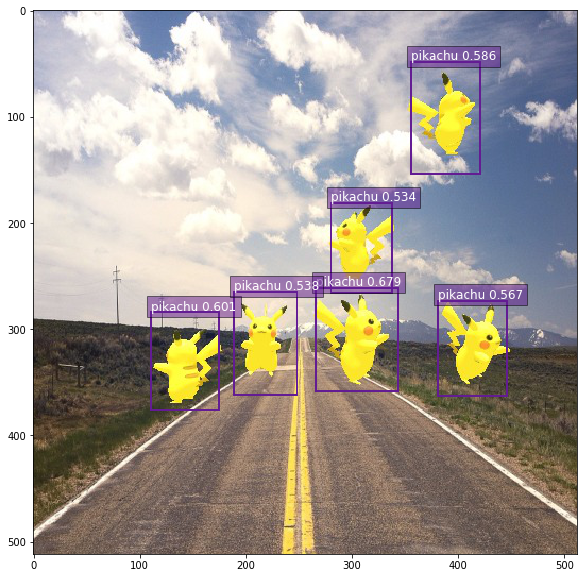

In [28]:
def display(img, out, thresh=0.5):
    import random
    import matplotlib as mpl
    mpl.rcParams['figure.figsize'] = (10,10)
    pens = dict()
    plt.clf()
    plt.imshow(img)
    for det in out:
        cid = int(det[0])
        if cid < 0:
            continue
        score = det[1]
        if score < thresh:
            continue
        if cid not in pens:
            pens[cid] = (random.random(), random.random(), random.random())
        scales = [img.shape[1], img.shape[0]] * 2
        xmin, ymin, xmax, ymax = [int(p * s) for p, s in zip(det[2:6].tolist(), scales)]
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False,
                             edgecolor=pens[cid], linewidth=2)
        plt.gca().add_patch(rect)
        text = class_names[cid]
        plt.gca().text(xmin, ymin-2, '{:s} {:.3f}'.format(text, score),
                       bbox=dict(facecolor=pens[cid], alpha=0.5),
                       fontsize=12, color='white')
    plt.show()
display(image[:, :, (2, 1, 0)], output[0].asnumpy(), thresh=0.45)

In [29]:
net.save_parameters("models/cnn_mxnet_pikachu.par")